# INTRODUCTION


In the previous notebook we implemented ArbitrayStyleTransfer Using Adaptive Instance Normalization. Through that model we were able to stylize any content image given a style image. It was fast and worked well for different image sizes. But it had several limitations too. The model does not generalize well and it stylized image does not look that well even though we were able to control the stylization amount. The mean reason for all of this is because the model transfer the statistics of style image to the content image using only mean and std which is clearly not enough to express the complex style features. 
In this notebook we will see another way of transfering the statistics of style image to the content image. Specifically we will try to implement [Universal Style Transfer via Feature Transforms](http://arxiv.org/abs/1705.08086) by Xun Huang et al. Most of the code and pretrained weights are taken from the official implementation of paper [deep-transfer ](https://github.com/pietrocarbo/deep-transfer). 

<br>

***Prerequisites:***
<br>
* Basic Python & Pytorch
* Familiar with neural style transfer
<br>


***NOTE:*** This notebook is a continuation of my [previous notebook](https://github.com/shoabahamed/Nueral-Style-Transfer-Models/blob/master/arbitarystyletransfer.ipynb) on arbitraystyletransfer. so it is recomended that you check that out first if you are not familiar with neural style transfer. 

# LIBRARIES

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset, RandomSampler
from torchvision import datasets
import torchvision.transforms.v2 as T
from torchvision import models
from torchvision.utils import make_grid, save_image


import os
import time
import random
from tqdm.notebook import tqdm
from path import Path

%matplotlib inline

# CONFIGURATIONS 

In [2]:
class config:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    batch_size = 8
    max_iterations = 10000
    learning_rate = 3.2e-4
    train_model = False
    seed = 42


    train_content_path =  "/kaggle/input/coco-2014-dataset-for-yolov3/coco2014/images/train2014"
    valid_content_path = "/kaggle/input/coco-2014-dataset-for-yolov3/coco2014/images/val2014"
    
    encoder_paths = dict(
        vgg1_1 = "/kaggle/input/style-transfer-models/pytorch/default/8/pretrained/vgg19-encoder/vgg_normalised_conv1_1.pth",
        vgg2_1 = "/kaggle/input/style-transfer-models/pytorch/default/8/pretrained/vgg19-encoder/vgg_normalised_conv2_1.pth",
        vgg3_1 = "/kaggle/input/style-transfer-models/pytorch/default/8/pretrained/vgg19-encoder/vgg_normalised_conv3_1.pth",
        vgg4_1 = "/kaggle/input/style-transfer-models/pytorch/default/8/pretrained/vgg19-encoder/vgg_normalised_conv4_1.pth",
        vgg5_1 = "/kaggle/input/style-transfer-models/pytorch/default/8/pretrained/vgg19-encoder/vgg_normalised_conv5_1.pth"
    )
    
    decoder_paths = dict(
        vgg1_1 = "/kaggle/input/style-transfer-models/pytorch/default/8/pretrained/vgg19-decoder/feature_invertor_conv1_1.pth",
        vgg2_1 = "/kaggle/input/style-transfer-models/pytorch/default/8/pretrained/vgg19-decoder/feature_invertor_conv2_1.pth",
        vgg3_1 = "/kaggle/input/style-transfer-models/pytorch/default/8/pretrained/vgg19-decoder/feature_invertor_conv3_1.pth",
        vgg4_1 = "/kaggle/input/style-transfer-models/pytorch/default/8/pretrained/vgg19-decoder/feature_invertor_conv4_1.pth",
        vgg5_1 = "/kaggle/input/style-transfer-models/pytorch/default/8/pretrained/vgg19-decoder/feature_invertor_conv5_1.pth"
    )
    
    
    
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  
    

    
seed_everything(config.seed) # this function does note effect everyting globally

# HELPER FUNCTIONS

In [3]:
def show_images(images, labels, rows=2, cols=2, figsize=(12, 5), title=""):
    """
    plot images of shape (B, C, H, W)
    
    images: (B, C, H, W)
    labels: List of strings
    """
    images = images.permute(0, 2, 3, 1).detach().cpu()  
    images = images.numpy()
    if cols is None:
        cols = max(1, len(images) // rows)
        
    if (rows, cols) == (1, 1):
        plt.imshow(images[0])
        plt.title(labels[0])
        plt.axis('off')
    else:
        fig, axes = plt.subplots(rows, cols, figsize=figsize)
        axes = axes.flatten()
        for img, label, ax in zip(images, labels, axes):
            ax.imshow(img)
            ax.set_title(f'{label}')
            ax.axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()    
    

def plot_losses(losses, labels, axes, xlabel="batches", ylabel='loss'):
    """
    losses: a 2d list of losses
    labels: a list of the loss names
    axes: the axes to plot the losses
    """
     
    assert len(losses) == len(labels), "length of losses and labels do not match"
    assert len(labels) == len(axes), "length of losses and axes do not match"
    
    for loss, label, ax in zip(losses, labels, axes):
        plt.sca(ax)
        plt.plot(loss, label=label)
        plt.legend()
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
    
def save_sample_images(model, sample_content_images, model_name, batches_done="last"):
    model.eval()
    with torch.no_grad():
        gen_img = model.generate_image(sample_content_images) 
        save_image(torch.cat([sample_content_images, gen_img], dim=2), 
                   f"./{model_name}/images/validation_images/{batches_done}.jpg", nrow=4)
    model.train()

# DATASET AND DATALOADERS

In [4]:
class FlatFolderDataset(Dataset):
    def __init__(self, path, transform):
        super(FlatFolderDataset, self).__init__()
        self.root = path
        self.paths = sorted(list(Path(path).glob("*")))
        self.transform = transform
        

    def __getitem__(self, index):
        path = self.paths[index]
        img = Image.open(str(path)).convert('RGB')
        img = self.transform(img)
        return img

    def __len__(self):
        return len(self.paths)

In [5]:
# transformations
def get_transform(train, img_size=None):
    transforms = []
    if img_size:
        transforms.append(T.Resize(size=img_size))
        
    if train:
        transforms.append(T.RandomCrop(size=(256, 256)))
        
    transforms.append(T.ToImage())
    transforms.append(T.ToDtype(torch.float32, scale=True))
    transforms.append(T.ToPureTensor())

    
    return T.Compose(transforms)

In [6]:
seed_everything(config.seed)


# train and valid transform of content images
train_transform = get_transform(True, img_size=512)
valid_transform = get_transform(False, img_size=(256, 256))

# creating train and valid dataset
train_content_dataset = FlatFolderDataset(config.train_content_path, train_transform)
valid_content_dataset = FlatFolderDataset(config.valid_content_path, valid_transform) 

# creating train and valid dataloader with batch size of 16
train_content_dataloader = DataLoader(train_content_dataset, batch_size=config.batch_size, shuffle=True, pin_memory=True, drop_last=True)
valid_content_dataloader = DataLoader(valid_content_dataset, batch_size=config.batch_size, shuffle=False, pin_memory=True, drop_last=True)

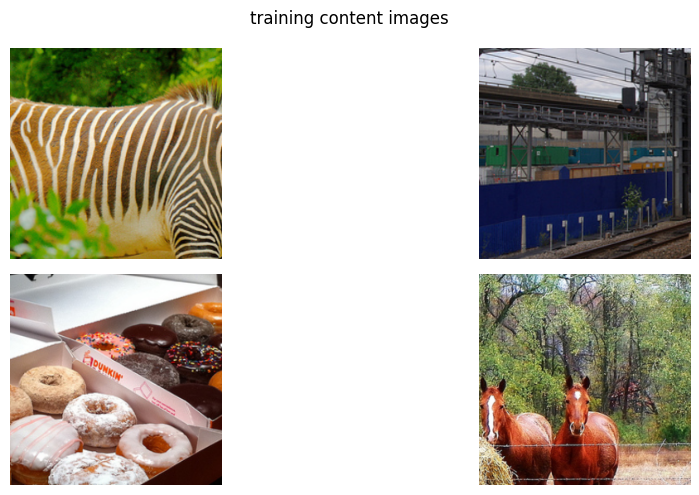

In [7]:
images = next(iter(train_content_dataloader))[:8]
labels = ["" for _ in range(len(images))]
show_images(images, labels, rows=2, title="training content images")

# MODEL

<img src="https://github.com/shoabahamed/Nueral-Style-Transfer-Models/blob/master/images/model_images/UniversalStyleTransfer/stylization.png?raw=true" style="display:block; margin: auto" title="Model Overview">
<p style="text-align: center; margin-top:1rem">Figure:<a href="http://arxiv.org/abs/1705.08086"> <u>Model Overview</u></a></p>

In the papers the authors took pretrained vgg19 network took the features map outputs of relu1_1, relu2_1, relu3_1, relu4_1, relu5_1 layers and then trained different decoders for different encoder outputs. During inference we we keep both the encoders and decoders fixed and transfer the statistics of style image to the content image through whitening and coloring. We will explain the WCT layer later in the notebook. For now as an example we will train a decoder for relu4_1 output of the encoder

# ENCODERS

In [8]:
vgg_encoder_conv1_1 = nn.Sequential( 
    nn.Conv2d(3,3,(1, 1)),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(3,64,(3, 3)),
    nn.ReLU(),
)

vgg_encoder_conv2_1 = nn.Sequential(
    nn.Conv2d(3,3,(1, 1)),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(3,64,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64,64,(3, 3)),
    nn.ReLU(),
    nn.MaxPool2d((2, 2),(2, 2),(0, 0)),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64,128,(3, 3)),
    nn.ReLU(),
)



vgg_encoder_conv3_1 = nn.Sequential( 
    nn.Conv2d(3,3,(1, 1)),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(3,64,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64,64,(3, 3)),
    nn.ReLU(),
    nn.MaxPool2d((2, 2),(2, 2),(0, 0)),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64,128,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128,128,(3, 3)),
    nn.ReLU(),
    nn.MaxPool2d((2, 2),(2, 2),(0, 0)),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128,256,(3, 3)),
    nn.ReLU(),
)



vgg_encoder_conv4_1 = nn.Sequential( 
        nn.Conv2d(3,3,(1, 1)),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(3,64,(3, 3)),
        nn.ReLU(),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(64,64,(3, 3)),
        nn.ReLU(),
        nn.MaxPool2d((2, 2),(2, 2),(0, 0)),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(64,128,(3, 3)),
        nn.ReLU(),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(128,128,(3, 3)),
        nn.ReLU(),
        nn.MaxPool2d((2, 2),(2, 2),(0, 0)),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(128,256,(3, 3)),
        nn.ReLU(),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(256,256,(3, 3)),
        nn.ReLU(),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(256,256,(3, 3)),
        nn.ReLU(),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(256,256,(3, 3)),
        nn.ReLU(),
        nn.MaxPool2d((2, 2),(2, 2),(0, 0)),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(256,512,(3, 3)),
        nn.ReLU(),
)


vgg_encoder_conv5_1 = nn.Sequential( 
    nn.Conv2d(3,3,(1, 1)),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(3,64,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64,64,(3, 3)),
    nn.ReLU(),
    nn.MaxPool2d((2, 2),(2, 2),(0, 0)),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64,128,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128,128,(3, 3)),
    nn.ReLU(),
    nn.MaxPool2d((2, 2),(2, 2),(0, 0)),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128,256,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256,256,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256,256,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256,256,(3, 3)),
    nn.ReLU(),
    nn.MaxPool2d((2, 2),(2, 2),(0, 0)),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256,512,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512,512,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512,512,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512,512,(3, 3)),
    nn.ReLU(),
    nn.MaxPool2d((2, 2),(2, 2),(0, 0)),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512,512,(3, 3)),
    nn.ReLU(),
)

# DECODERS

In [9]:
vgg_decoder_conv1_1 = nn.Sequential( # Sequential,
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64,3,(3, 3)),
)

vgg_decoder_conv2_1 = nn.Sequential( 
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128,64,(3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64,64,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64,3,(3, 3)),
)

vgg_decoder_conv3_1 = nn.Sequential( # Sequential,
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256,128,(3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128,128,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128,64,(3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64,64,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64,3,(3, 3)),
)


vgg_decoder_conv4_1 = nn.Sequential( 
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512,256,(3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256,256,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256,256,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256,256,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256,128,(3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128,128,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128,64,(3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64,64,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64,3,(3, 3)),
)


vgg_decoder_conv5_1 = nn.Sequential( # Sequential,
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512,512,(3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512,512,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512,512,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512,512,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512,256,(3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256,256,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256,256,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256,256,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256,128,(3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128,128,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128,64,(3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64,64,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64,3,(3, 3)),
)

# TRAINING

<img src="https://github.com/shoabahamed/Nueral-Style-Transfer-Models/blob/master/images/model_images/UniversalStyleTransfer/decoder_loss.png?raw=true" style="display:block; margin: auto" title="Model Overview">
<p style="text-align: center; margin-top:1rem">Figure:<a href="http://arxiv.org/abs/1705.08086"> <u>Image Reconstruction Loss</u></a></p>

There are two losses involved in when training the decoder. 
1. Pixel reconstruction loss: The l2 loss between input image and decoder output image(The first part in the equation)
2. Feature loss: The l2 loss between input image feature maps and output image feature maps for X layer



In [10]:
class Network(nn.Module):
    def __init__(self, encoder, decoder):
        super(Network, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
        for param in self.encoder.parameters():
            param.requires_grad = False

    def forward(self, content_img):
        feats = self.encoder(content_img)
        gen_img = self.decoder(feats)
        per_pixel_loss, feature_loss = self.calculate_loss(content_img, gen_img, feats, self.encoder(gen_img))
        
        return per_pixel_loss, feature_loss
    
    def calculate_loss(self, content_img, generated_img, content_feats, generated_feats):
        per_pixel_loss = F.mse_loss(content_img, generated_img)
        feature_loss = F.mse_loss(content_feats, generated_feats)

        return per_pixel_loss, feature_loss    

    def generate_image(self, content_img):
        gen_img = self.decoder(self.encoder(content_img))
        
        return gen_img.clip(0, 1)

In [11]:
def training_loop(model_name, model, optimizer, scheduler, train_content_dataloader, sample_content_images,
                  checkpoint_model=None, evaluate_interval=None, checkpoint_interval=5000):
    
    print("Training model")
    seed_everything(config.seed)
    
    # creating directories for storing sample images and model checkpoints
    os.makedirs(f"./{model_name}/images/validation_images", exist_ok=True)
    os.makedirs(f"./{model_name}/checkpoints", exist_ok=True)
    
    # loading checkpoing model if exists
    if checkpoint_model:
        model.decoder.load_state_dict(torch.load(checkpoint_model, map_location=config.device, weights_only=True))
        print("Loaded checkpont decoder model")
    
    total_batches = config.max_iterations
    progress_bar = tqdm(total=total_batches, desc=f"batches done")
    train_per_pixel_batch_losses = []
    train_feature_batch_losses = [] 
    mean_per_pixel_loss = 0.0
    mean_feature_loss = 0.0
    start_time = time.time()
    train_content_iter =  iter(train_content_dataloader)
    
    model.train()
    for batch_id in range(total_batches):    
        optimizer.zero_grad()

        try:
            content_img = next(train_content_iter)
        except StopIteration:
            train_content_iter = iter(train_content_dataloader)
            content_img = next(train_content_iter)
  
        
        # move the images to appropiate devices and generate stylized images
        content_img = content_img.to(config.device)

        per_pixel_loss, feature_loss = model(content_img)
        loss = per_pixel_loss + feature_loss
        loss.backward()
        
        

        optimizer.step()
        scheduler.step()

        train_per_pixel_batch_losses.append(per_pixel_loss.item())
        train_feature_batch_losses.append(feature_loss.item())
        
        mean_per_pixel_loss += per_pixel_loss.item() / evaluate_interval
        mean_feature_loss += feature_loss.item() / evaluate_interval
        batches_done = batch_id + 1 

        # saving the model at regular interval
        if checkpoint_interval > 0 and batches_done%checkpoint_interval == 0:
            torch.save(model.decoder.state_dict(), f"./{model_name}/checkpoints/{model_name}_decoder_{batches_done}.pth")

        # saving model output s at regular interval for 8 sample images
        if (evaluate_interval is not None and batches_done % evaluate_interval == 0):
            save_sample_images(model, sample_content_images, model_name, batches_done)
            end_time = time.time()
            train_time = end_time - start_time
            print(f"batches_ran: {batches_done} | " + f"time: {train_time/60:.4f} min | " +  
              f"train per pixel loss: {mean_per_pixel_loss:.4f} | train feature loss: {mean_feature_loss:.4f} | " + 
              f"total loss: {mean_per_pixel_loss + mean_feature_loss:.4f}")
            mean_per_pixel_loss = 0.0
            mean_feature_loss = 0.0
            start_time = time.time()

        progress_bar.update(1)

            
    save_sample_images(model, sample_content_images, model_name, "last") 
    
    print(f"Trained model for {total_batches} iterations")
    print("Saving final model")
    torch.save(model.decoder.state_dict(), f"./{model_name}/checkpoints/{model_name}_decoder_last_checkpoint_{batches_done}.pth")
    return train_per_pixel_batch_losses, train_feature_batch_losses

***NOTE:*** One thing to mention is that is that I have tried training the decoder with pytorch vgg19 model weights but the result was not good for some reason. I spent quite a time on this but was not able to find out why. 

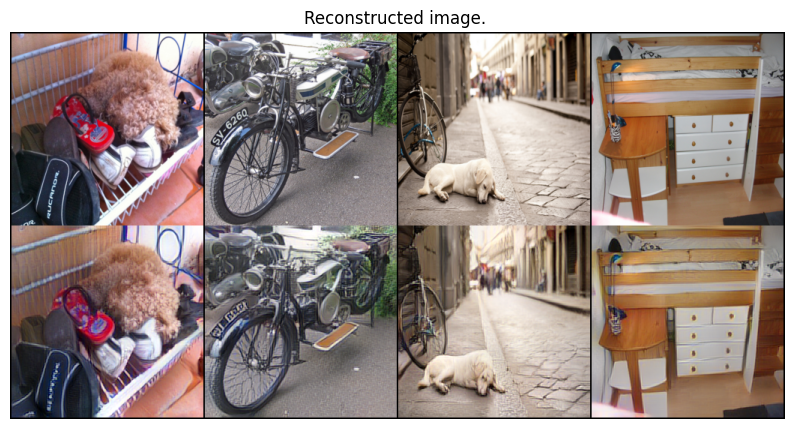

In [12]:
vgg_encoder = vgg_encoder_conv4_1.to(config.device)
vgg_decoder = vgg_decoder_conv4_1.to(config.device)
vgg_encoder.load_state_dict(torch.load(config.encoder_paths['vgg4_1'], weights_only=True, map_location=config.device))

model = Network(vgg_encoder, vgg_decoder)

if config.train_model:
    evaluate_interval = 1000
    checkpoint_interval = 5000
    optimizer = torch.optim.Adam(model.decoder.parameters(), lr=config.learning_rate)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=config.learning_rate, total_steps=config.max_iterations)


    sample_content_images = next(iter(valid_content_dataloader))[:4].to(config.device)
    train_per_pixel_batch_losses, train_feature_batch_losses = training_loop("decoder4_1", model, optimizer, scheduler,
                                                                        train_content_dataloader, sample_content_images,
                                                                        checkpoint_model=None, evaluate_interval=evaluate_interval,
                                                                        checkpoint_interval=checkpoint_interval)
    
    fig, axes = plt.subplots(nrows=1, ncols=2)
    plot_losses([train_per_pixel_batch_losses, train_feature_batch_losses], ['per_pixel_loss', 'feature_loss'], axes=axes)
    plt.tight_layout()
else:
    decoder_checkpoint_model = "/kaggle/input/style-transfer-models/pytorch/default/8/trained/UniversalStyleTransfer/decoder4_1_decoder_10000.pth"
    model.decoder.load_state_dict(torch.load(decoder_checkpoint_model, map_location=config.device, weights_only=True))

    sample_content_images = next(iter(valid_content_dataloader))[:4].to(config.device)

    model.eval()
    with torch.no_grad():
        gen_images = model.generate_image(sample_content_images)


    plt.figure(figsize=(10, 10))
    images = make_grid(torch.cat([sample_content_images, gen_images], dim=2), nrow=4)
    plt.imshow(images.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.title("Reconstructed image. ")
    plt.show()

# STYLIZING IMAGES

<img src="https://github.com/shoabahamed/Nueral-Style-Transfer-Models/blob/master/images/model_images/UniversalStyleTransfer/multi_stylization.png?raw=true" style="display:block; margin: auto" title="Model Overview">
<p style="text-align: center; margin-top:1rem">Figure:<a href="http://arxiv.org/abs/1705.08086"> <u>Multilevel Stylization</u></a></p>

To achieve good stylization the authors used a multilevel sylization. In this method we will first pass the content image through encoder5 then perform WCT then pass the transformed features to decoder5 to get a stylized image. We will again pass the stylized image to encoder4 and do the same thing untill we pass the stylized image through decoder1. We do stylization in a multistep process because higher layer features capture more complicated local structures, while lower layer features carry more low-level information.

In [13]:
# the line below loads a image to stylize
!wget -O content_img.jpg https://raw.githubusercontent.com/shoabahamed/Nueral-Style-Transfer-Models/master/images/example_content_images/small_room.jpg
# the line below downloads our style image
!wget -O style_img.jpg https://raw.githubusercontent.com/shoabahamed/Nueral-Style-Transfer-Models/master/images/example_style_images/edtaonisl.jpg

--2024-11-09 05:07:44--  https://raw.githubusercontent.com/shoabahamed/Nueral-Style-Transfer-Models/master/images/example_content_images/small_room.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 378622 (370K) [image/jpeg]
Saving to: 'content_img.jpg'

content_img.jpg     100%[===================>] 369.75K  1.77MB/s    in 0.2s    

2024-11-09 05:07:45 (1.77 MB/s) - 'content_img.jpg' saved [378622/378622]

--2024-11-09 05:07:46--  https://raw.githubusercontent.com/shoabahamed/Nueral-Style-Transfer-Models/master/images/example_style_images/edtaonisl.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|

In [14]:
class StyleTransfer(nn.Module):
    def __init__(self):
        super(StyleTransfer, self).__init__()
        # load pre-trained network
        self.encoder1 = vgg_encoder_conv1_1
        self.encoder2 = vgg_encoder_conv2_1
        self.encoder3 = vgg_encoder_conv3_1
        self.encoder4 = vgg_encoder_conv4_1
        self.encoder5 = vgg_encoder_conv5_1
        
        self.decoder1 = vgg_decoder_conv1_1
        self.decoder2 = vgg_decoder_conv2_1
        self.decoder3 = vgg_decoder_conv3_1
        self.decoder4 = vgg_decoder_conv4_1
        self.decoder5 = vgg_decoder_conv5_1
        
        
        self._load_weights_()
        
    
    
    def forward(self, content_img, style_img , alpha=0.5):
        
        sF5 = self.encoder5(style_img)
        cF5 = self.encoder5(content_img)
        csF5 = self.whiten_and_color_transform(cF5,sF5,alpha)
        Im5 = self.decoder5(csF5)

        sF4 = self.encoder4(style_img)
        cF4 = self.encoder4(Im5)
        csF4 = self.whiten_and_color_transform(cF4,sF4,alpha)
        Im4 = self.decoder4(csF4)

        sF3 = self.encoder3(style_img)
        cF3 = self.encoder3(Im4)
        csF3 = self.whiten_and_color_transform(cF3,sF3,alpha)
        Im3 = self.decoder3(csF3)

        sF2 = self.encoder2(style_img)
        cF2 = self.encoder2(Im3)
        csF2 = self.whiten_and_color_transform(cF2,sF2,alpha)
        Im2 = self.decoder2(csF2)

        sF1 = self.encoder1(style_img)
        cF1 = self.encoder1(Im2)
        csF1 = self.whiten_and_color_transform(cF1,sF1,alpha)
        Im1 = self.decoder1(csF1)

        return Im1
    
    
    
    def whiten_and_color_transform(self, content_features, style_features, alpha):
        """
        content_features: (1, C, Height, Width)
        style_features: (1, C, Height, Width)
        """
        

        content_features = content_features.double()
        style_features = style_features.double()
        feature_shape = content_features.size()
        B, C, H, W =  feature_shape
        
        
        # (1, C, H, W) -> (C, H*W)
        content_features = content_features.view(C, -1)
        style_features = style_features.view(C, -1)

        # whitened_features: (C, H*W)
        whitened_features = self.get_whitened_features(content_features)
        # colored_features: (C, H*W)
        colored_features = self.get_colored_features(style_features, whitened_features)

        # transfromed_features: (1, C, H, W)
        transformted_features = colored_features.view(feature_shape)
        transformted_features = alpha * transformted_features + (1.0 - alpha) * content_features.view(feature_shape)

        return transformted_features.float()
    
    

    def get_whitened_features(self, content_features):
        """
        content_features: (C, H*W)
        """

        feature_shape = content_features.size()
        
        
        c_mean = torch.mean(content_features, dim=1, keepdims=True) # (C, 1)
        c_mean = c_mean.expand_as(content_features) # c_mean: (C, H*W)
        content_features = content_features - c_mean    # content_features: (C, H*W); c_mean: (C, H*W)

        # content_conv: (C, C)
        # c_u: (C, C); c_e: (C), c_v: (C, C)
        content_conv = torch.mm(content_features,content_features.t()).div(feature_shape[1]-1)
        c_u,c_e,c_v = torch.svd(content_conv,some=False)
        
        k_c = feature_shape[0]
        for i in range(feature_shape[0]):
            if c_e[i] < 0.00001:
                k_c = i
                break

        # whitening transfrom according to the equation in the paper
        # c_d: (K)
        c_d = (c_e[0:k_c]).pow(-0.5)
        step1 = torch.mm(c_v[:,0:k_c],torch.diag(c_d)) # (C, K) @ (K, K) -> (C, K)
        step2 = torch.mm(step1,(c_v[:,0:k_c].t()))    # (C, K) @ (K, C) -> (C, C)
        whiten_cF = torch.mm(step2,content_features)  # (C, C) @ (C, H*W) -> (C, H*W)

        return whiten_cF

    def get_colored_features(self, style_features, whitened_featuers):
        """
        style_features: (C, H*W)
        whitened_featuers: (C, H*W)
        Note: The code here is same as whitening transform just that we transfrom the whitened features rather than style features at the end
        """
        feature_shape = style_features.size() 
        s_mean = torch.mean(style_features, dim=1, keepdims=True)
        s_mean = s_mean.expand_as(style_features)
        style_features = style_features -  s_mean


        styleConv = torch.mm(style_features,style_features.t()).div(feature_shape[1]-1)
        s_u,s_e,s_v = torch.svd(styleConv,some=False)

        k_s = feature_shape[0]
        for i in range(feature_shape[0]):
            if s_e[i] < 0.00001:
                k_s = i
                break


        s_d = (s_e[0:k_s]).pow(0.5)
        colored_features = torch.mm(torch.mm(torch.mm(s_v[:,0:k_s],torch.diag(s_d)),(s_v[:,0:k_s].t())),whitened_featuers)
        colored_features = colored_features + s_mean

        return colored_features
    
    
    def _load_weights_(self):
        print("loaded checkpoing weights")
        vgg_encoder_conv1_1.load_state_dict(torch.load(config.encoder_paths['vgg1_1'], weights_only=True, map_location=config.device))
        vgg_encoder_conv2_1.load_state_dict(torch.load(config.encoder_paths['vgg2_1'], weights_only=True, map_location=config.device))
        vgg_encoder_conv3_1.load_state_dict(torch.load(config.encoder_paths['vgg3_1'], weights_only=True, map_location=config.device))
        vgg_encoder_conv4_1.load_state_dict(torch.load(config.encoder_paths['vgg4_1'], weights_only=True, map_location=config.device))
        vgg_encoder_conv5_1.load_state_dict(torch.load(config.encoder_paths['vgg5_1'], weights_only=True, map_location=config.device))


        vgg_decoder_conv1_1.load_state_dict(torch.load(config.decoder_paths['vgg1_1'], weights_only=True, map_location=config.device))
        vgg_decoder_conv2_1.load_state_dict(torch.load(config.decoder_paths['vgg2_1'], weights_only=True, map_location=config.device))
        vgg_decoder_conv3_1.load_state_dict(torch.load(config.decoder_paths['vgg3_1'], weights_only=True, map_location=config.device))
        vgg_decoder_conv4_1.load_state_dict(torch.load(config.decoder_paths['vgg4_1'], weights_only=True, map_location=config.device))
        vgg_decoder_conv5_1.load_state_dict(torch.load(config.decoder_paths['vgg5_1'], weights_only=True, map_location=config.device))
        
        
        # Move each encoder and decoder to the desired device
        self.to(config.device)



<img src="https://github.com/shoabahamed/Nueral-Style-Transfer-Models/blob/master/images/model_images/UniversalStyleTransfer/control.png?raw=true" style="display:block; margin: auto" title="Model Overview">
<p style="text-align: center; margin-top:1rem">Figure:<a href="http://arxiv.org/abs/1705.08086"> <u>Controlling Stylization</u></a></p>

Through increasing the value of alpha we can increase the stylization amount. The highest value is 1.0 and lowest is 
* fc = input image feature map
* fcs = whitened and colored feature maps

In [15]:
alphas = [0.0, 0.3, 0.6, 1.0]
styletransfer = StyleTransfer()


content_img = valid_transform(Image.open("/kaggle/working/content_img.jpg")).unsqueeze(0).to(config.device)
style_img = valid_transform(Image.open("/kaggle/working/style_img.jpg")).unsqueeze(0).to(config.device)
stylized_images = [content_img, style_img]

for alpha in alphas:
    with torch.no_grad():
        stylized_images.append(styletransfer(content_img, style_img, alpha=alpha))

loaded checkpoing weights


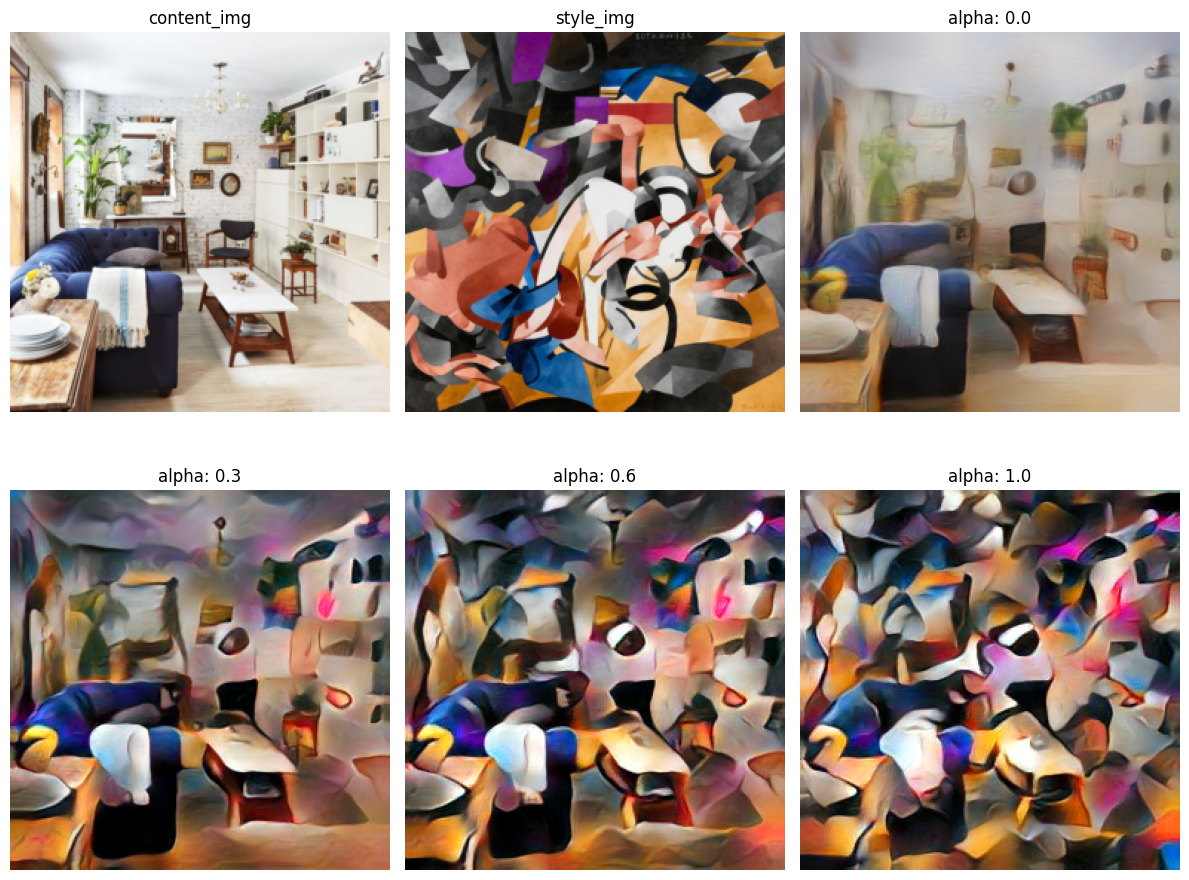

In [16]:
show_images(torch.cat(stylized_images, dim=0), ['content_img', "style_img"]+[f"alpha: {alphas[i]}" for i in range(len(alphas))],
            rows=2, cols=3, figsize=(12, 10))

# WHITENING AND COLORING(WCT)

***NOTE:*** The next section assumes that you have basic understanding of linear algebra


I would not call myself very good at math. So rather than explaining in mathematical way I will try to explain what the wct layer does. But if you want to study more in dept you can check out the resources below

* Higly Recommended: [Preprocessing for deep learning: from covariance matrix to image whitening](https://medium.com/free-code-camp/https-medium-com-hadrienj-preprocessing-for-deep-learning-9e2b9c75165c) 
* [The mathematical and geographic understanding of Singular Value Decomposition(SVD)](https://medium.com/intuition/the-mathematical-and-geographic-understanding-of-singular-value-decomposition-svd-8da2297797c6)
* [Deep Learning Book Series · 2.8 Singular Value Decomposition](https://hadrienj.github.io/posts/Deep-Learning-Book-Series-2.8-Singular-Value-Decomposition/)
* [Computing the Singular Value Decomposition | MIT 18.06SC Linear Algebra, Fall 2011](https://youtu.be/cOUTpqlX-Xs?feature=shared)

* [Singular Value Decomposition (SVD): Matrix Approximation](https://youtu.be/xy3QyyhiuY4?feature=shared)

First of well what does the whitening layer do? We can see that by decoding the feature maps after the whitening transformation.

In [17]:
with torch.no_grad():
    features = styletransfer.encoder5(style_img)
    B, C, H, W = features.size()
    
    featuresView = features.double().view(B, C, -1).squeeze(0).clone()
    whitened_features = styletransfer.get_whitened_features(featuresView).view(B, C, H, W).float()
    
    whitened_image = styletransfer.decoder5(whitened_features)

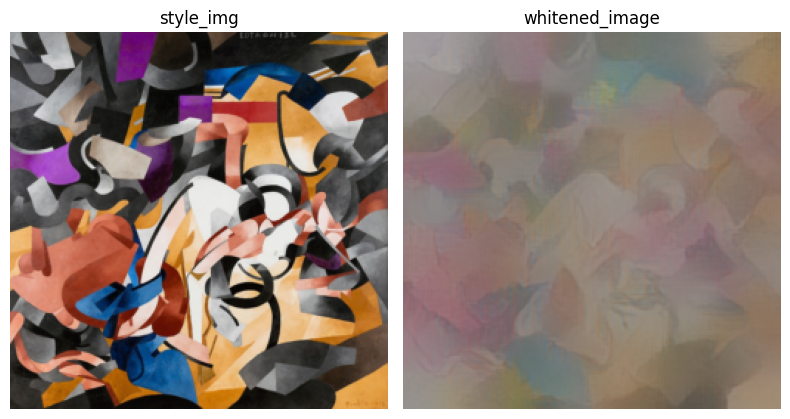

In [18]:
show_images(torch.cat([style_img, whitened_image], dim=0), ['style_img', "whitened_image"], rows=1, cols=2, figsize=(8, 5))


As you can see after whitening transformation a lot of the style has been stripped away. In the whitening step the content image gets stripped of most of it's style's and this what we want we want to remove all information related to style(colors, patterns etc) from the content image during the coloring phase we want to pass the style information from the style image. 


According to the authors-
> the whitening step helps peel off the style from an input image while preserving the global content structure.

Okay we understand that whitening step removes style information but how does it do do that?

In the paper the authors said that:
> we transform $f_c$ linearly so that we obtain $f_c$ such that the feature maps are uncorrelated  $(f_cf_c^T  = I)$

So we want to transform the content features in such a way that all the features become uncorreleated. By doing do we will retain the global structure but lose lot of the small details like color, strokes etc. Below you can see the the covariance matrix of the feature maps before and after whitening transformation

***NOTE:*** I have rescaled the covariance matrix for fair comprarison

In [19]:
def calculate_covariance(features, scale=True):
    """
    features: (1, C, H, W)
    """
    B, C, H, W = features.size()
    feats = features.clone().view(C, -1)

    c_mean = torch.mean(feats, dim=1, keepdims=True) 
    c_mean = c_mean.expand_as(feats) 
    feats = feats - c_mean    

    cov = torch.mm(feats,feats.t()).div(H*W-1)
    
    if scale:
        cov = min_max_scale(cov)
    
    return cov


def min_max_scale(matrix):
    min_val = matrix.min()
    max_val = matrix.max()
    return (matrix - min_val) / (max_val - min_val) 

In [20]:
pre_cov = calculate_covariance(features).cpu()
whitened_cov = calculate_covariance(whitened_features).cpu()

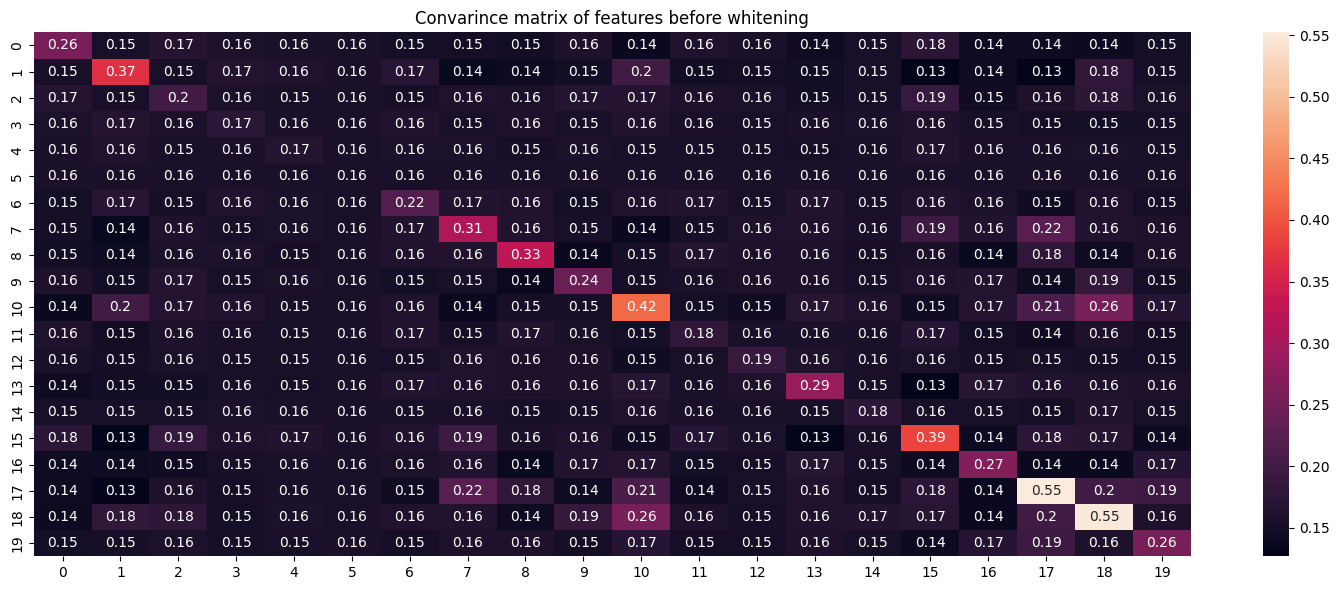

In [21]:
fig, axes = plt.subplots(1, 1, figsize=(15, 6))

sns.heatmap(pre_cov[:20, :20], ax=axes, annot=True)
plt.title("Convarince matrix of features before whitening")
plt.tight_layout()

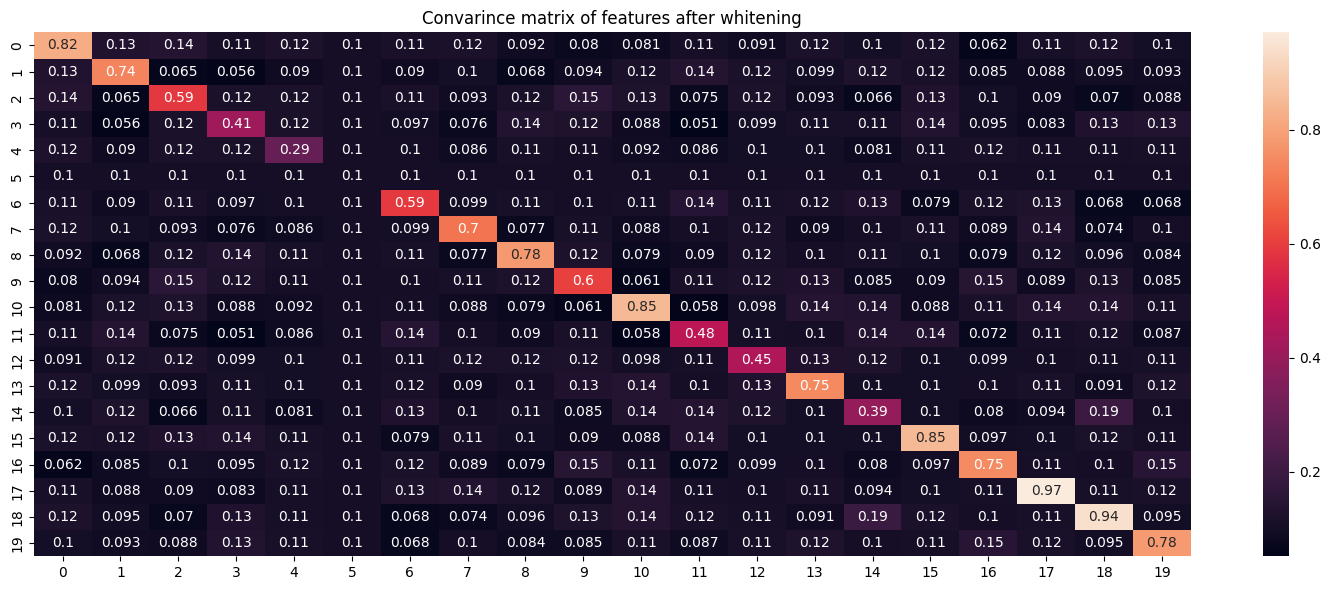

In [22]:
fig, axes = plt.subplots(1, 1, figsize=(15, 6))

sns.heatmap(whitened_cov[:20, :20], ax=axes, annot=True)
plt.title("Convarince matrix of features after whitening")
plt.tight_layout()

We can clearly see that although not complemetly identity matrix in the whitened covariance matrix a the feature maps have been mostly decorrelated.

As for the of I decorrelation happen I would highly recommend that you read this blog post [Preprocessing for deep learning: from covariance matrix to image whitening](https://medium.com/free-code-camp/https-medium-com-hadrienj-preprocessing-for-deep-learning-9e2b9c75165c) 

> The eigenvectors of the covariance matrix give you the direction that maximizes the variance. So we can decorrelate the data by projecting it using the eigenvectors. This will have the effect to apply the rotation needed and remove correlations between the dimensions. (From the blog post)

The steps are: 
1. Calculate the covariance matrix
2. Calculate the eigenvectors of the covariance matrix
3. Apply the matrix of eigenvectors to the data — this will apply the rotation

Since our matrix is not a square matrix we need to use singular value decomposition which is basically decomposition for non square matrices

# KEY ACHIEVEMENTS & LIMITATIONS

Through this model we are able stylize any content, style image pair. Stylization works for all image resolution. We are also able to control the stylization amount. The stylized image looked quite similar in quality to that of A Neural Algorithm of Artistic Style paper. But it has limitations too. For good stylization we have to pass the image multiple times through multiple models which is slow for high resolution images.

# REFERENCES

* [Universal Style Transfer via Feature Transforms](http://arxiv.org/abs/1705.08086)
* [Model Weights](https://github.com/pietrocarbo/deep-transfer)
* [Coco14](https://www.kaggle.com/datasets/jeffaudi/coco-2014-dataset-for-yolov3)
* [Preprocessing for deep learning: from covariance matrix to image whitening](https://medium.com/free-code-camp/https-medium-com-hadrienj-preprocessing-for-deep-learning-9e2b9c75165c) 
* [The mathematical and geographic understanding of Singular Value Decomposition(SVD)](https://medium.com/intuition/the-mathematical-and-geographic-understanding-of-singular-value-decomposition-svd-8da2297797c6)
* [Deep Learning Book Series · 2.8 Singular Value Decomposition](https://hadrienj.github.io/posts/Deep-Learning-Book-Series-2.8-Singular-Value-Decomposition/)
* [Computing the Singular Value Decomposition | MIT 18.06SC Linear Algebra, Fall 2011](https://youtu.be/cOUTpqlX-Xs?feature=shared)

* [Singular Value Decomposition (SVD): Matrix Approximation](https://youtu.be/xy3QyyhiuY4?feature=shared)

# WHAT NEXT
As we have seen at test time style transfer is slow. To mitigate this issue another paper came out the following year [Learning Linear Transformations for Fast Arbitrary Style Transfer](https://arxiv.org/abs/1808.04537). In this paper the authors removed the wct layer and created a trained module which learns the transformation during training. But we won't implement this as they have published the official training code in this repo https://github.com/sunshineatnoon/LinearStyleTransfer. 
So in the next notebook we will switch things around and use gans to apply style transfer specially we will implement CycleGan